In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [15]:
N = 100
L = 1000
T = 20

In [16]:
np.empty?

Docstring:
empty(shape, dtype=float, order='C', *, device=None, like=None)

Return a new array of given shape and type, without initializing entries.

Parameters
----------
shape : int or tuple of int
    Shape of the empty array, e.g., ``(2, 3)`` or ``2``.
dtype : data-type, optional
    Desired output data-type for the array, e.g, `numpy.int8`. Default is
    `numpy.float64`.
order : {'C', 'F'}, optional, default: 'C'
    Whether to store multi-dimensional data in row-major
    (C-style) or column-major (Fortran-style) order in
    memory.
device : str, optional
    The device on which to place the created array. Default: ``None``.
    For Array-API interoperability only, so must be ``"cpu"`` if passed.

    .. versionadded:: 2.0.0
like : array_like, optional
    Reference object to allow the creation of arrays which are not
    NumPy arrays. If an array-like passed in as ``like`` supports
    the ``__array_function__`` protocol, the result will be defined
    by it. In this case, it

In [17]:
x = np.empty((N, L), np.float32)
x

array([[-7.2564359e+17,  7.4268819e-43, -5.7037386e+17, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 3.8115318e-43,  2.2841165e-43,            nan, ...,
         2.4802983e-43,  3.5873241e-43,  8.0356059e-41],
       [ 3.4752202e-43,  2.4943113e-43,  3.5873241e-43, ...,
        -3.5436668e-13, -3.6029527e+16, -1.9669535e-11],
       [ 9.1456702e-37, -1.3314494e-32,  2.3694284e-38, ...,
                   nan,            nan, -3.0516536e-05]],
      shape=(100, 1000), dtype=float32)

In [21]:
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
x

array([[  27.,   28.,   29., ..., 1024., 1025., 1026.],
       [ -22.,  -21.,  -20., ...,  975.,  976.,  977.],
       [ -31.,  -30.,  -29., ...,  966.,  967.,  968.],
       ...,
       [  34.,   35.,   36., ..., 1031., 1032., 1033.],
       [  41.,   42.,   43., ..., 1038., 1039., 1040.],
       [  41.,   42.,   43., ..., 1038., 1039., 1040.]],
      shape=(100, 1000), dtype=float32)

In [23]:
y = np.sin(x/1.0/T).astype(np.float32)
y

array([[ 0.9757234 ,  0.98544973,  0.992713  , ...,  0.80431294,
         0.83300525,  0.85961556],
       [-0.89120734, -0.86742324, -0.841471  , ..., -0.9984706 ,
        -0.9944597 , -0.98796326],
       [-0.99978375, -0.997495  , -0.992713  , ..., -0.923117  ,
        -0.94118106, -0.9568938 ],
       ...,
       [ 0.9916648 ,  0.98398596,  0.9738476 , ...,  0.9593011 ,
         0.9722154 ,  0.9827005 ],
       [ 0.8873624 ,  0.8632094 ,  0.83689874, ...,  0.9979704 ,
         0.99354064,  0.9866276 ],
       [ 0.8873624 ,  0.8632094 ,  0.83689874, ...,  0.9979704 ,
         0.99354064,  0.9866276 ]], shape=(100, 1000), dtype=float32)

C:\Users\zelaw\AppData\Local\Temp\ipykernel_12252\83319599.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


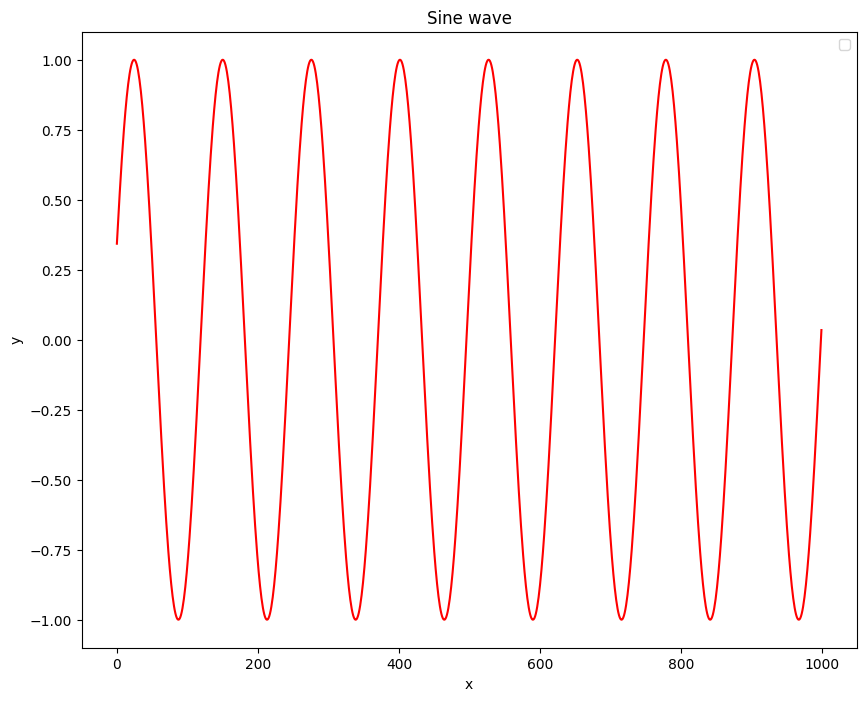

In [20]:
plt.figure(figsize=(10, 8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(np.arange(x.shape[1]), y[0, :], 'r')
plt.legend()
plt.show()

In [24]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        # N, 100
        outputs = []
        n_samples = x.size(0)

        h_t = torch.zeros(n_samples, self.n_hidden, dtype=x.dtype)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=x.dtype)
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=x.dtype)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=x.dtype)

        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        outputs = torch.cat(outputs, dim=1)
        return outputs       